## Variational Autoencoders

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

## Prepare the Dataset

In [5]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [8]:
def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1))
  return image

def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  split_name = 'train' if is_validation else 'test'
  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)
  
  return dataset

In [9]:
train_dataset = get_dataset(map_image)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the model

### Sampling class

In [10]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

In [11]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='encode_conv1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='encode_conv2')(x)
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Flatten(name='encode_flatten')(batch_2)
  # arbitrarily used 20 units
  x = tf.keras.layers.Dense(20, activation='relu', name='encode_dense')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)

  return mu, sigma, batch_2.shape

In [12]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])
  return model, conv_shape

### Decoder

In [13]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation='relu', name='decode_dense1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='decode_reshape')(x)
  x = tf.keras.layers.Convolution2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv2d_2')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Convolution2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='decode_conv2d_3')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Convolution2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name='decode_final')(x)
  return x

In [14]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [15]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5
  return kl_loss

### VAE model

In [16]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu, sigma, z = encoder(inputs)
  reconstructed = decoder(z)
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
  # add KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)
  return model

In [17]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim, input_shape)
  decoder = decoder_model(latent_dim, conv_shape)
  vae = vae_model(encoder, decoder, input_shape)
  return encoder, decoder, vae

In [18]:
encoder, decoder, vae = get_models(input_shape=(28, 28, 1), latent_dim=LATENT_DIM)

## Train the model

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [20]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

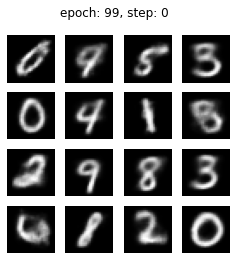

Epoch: 99 step: 0 mean loss = 150.72404


In [22]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

epochs = 100
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)

      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784
      loss += sum(vae.losses)
    
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 100 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))
